In [2]:
#create dictionaries of data with exposure as keys
stdDict1 = {}
meanDict1 = {}
varDict1 = {}

In [3]:
#setup
from FrontPanelAPI import ok
import time
import numpy as np
import cv2
import math
import matplotlib.pyplot as plt

dev = ok.okCFrontPanel()
deviceCount = dev.GetDeviceCount()
for i in range(deviceCount):
    print 'Device[{0}] Model: {1}'.format(i, dev.GetDeviceListModel(i))
    print 'Device[{0}] Serial: {1}'.format(i, dev.GetDeviceListSerial(i))

dev = ok.okCFrontPanel()
dev.OpenBySerial("")
dev.ConfigureFPGA("ok_imager.bit")

Device[0] Model: 21
Device[0] Serial: 143400091C


0

In [ ]:
#please close aperture

In [ ]:
#grab 100 frames with aperture closed to obtain offset
dev = ok.okCFrontPanel()
deviceCount = dev.GetDeviceCount()
for i in range(deviceCount):
    print 'Device[{0}] Model: {1}'.format(i, dev.GetDeviceListModel(i))
    print 'Device[{0}] Serial: {1}'.format(i, dev.GetDeviceListSerial(i))

dev = ok.okCFrontPanel()
dev.OpenBySerial("")
dev.ConfigureFPGA("ok_imager.bit")
if dev.IsFrontPanelEnabled():
    row = 160
    N_adc = 4
    N_adcCh = 3
    N_mux = 46
    col = N_adc*N_adcCh*N_mux
    datain128 = bytearray(262144)
    datain1 = bytearray(88320)
    im = np.zeros((row ,col), np.uint8)
    im1 = np.zeros((79 ,60), np.uint8)
    im2 = np.zeros((79 ,60), np.uint8)
    
    exp =3.0
    exposure = int(10**exp)
    
    while exp<4.7:
        print exposure
        offset1 = np.zeros((79,60))
        elsecounter = 0   
        rep = 0
        dev.SetWireInValue(0x11,exposure)
        dev.SetWireInValue(0x12,1)
        dev.SetWireInValue(0x13,0)
        dev.SetWireInValue(0x14,0)
        dev.SetWireInValue(0x15, 0xfff003ff)
        dev.UpdateWireIns()
        time.sleep(0.01)
        # assert reset signal to initialize the FIFO
        dev.SetWireInValue(0x10, 0xff, 0x01)
        dev.UpdateWireIns()
        # deactivate reset signal and activate counter.
        dev.SetWireInValue(0x10, 0x00, 0x01)
        dev.UpdateWireIns()
        time.sleep(0.1)
        while rep<120:
            dev.UpdateTriggerOuts()
            # If the FIFO is full, read everything and display one frame only
            if dev.IsTriggered(0x6A, 0x01) == True:
                dev.ReadFromPipeOut(0xA0, datain128)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain128[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                #im = im/255
                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):
                    rep+=1
                    if rep>20: #to account for noise at the beginning
                        offset1 +=im1

            # If one frame is ready in FIFO
            elif dev.IsTriggered(0x6A, 0x02) == True:
                dev.ReadFromPipeOut(0xA0, datain1)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain1[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                #im = im/255
                im1[:,:] = im[1:80,142:262:2]
                rep+=1
                if np.any(im1):
                    if rep>20: #to account for noise at the beginning
                        offset1 +=im1
            else:
                elsecounter += 1
                print elsecounter
                if elsecounter>10:
                    elsecounter = 0
                    # assert reset signal to initialize the FIFO
                    dev.SetWireInValue(0x10, 0xff, 0x01)
                    dev.UpdateWireIns()
                    # deactivate reset signal and activate counter.
                    dev.SetWireInValue(0x10, 0x00, 0x01)
                    dev.UpdateWireIns()

            if (rep)%10 ==0:
                print rep 
        offset1= offset1/100
        cv2.imwrite(str(exposure)+'.png',offset1) #save offset images
        exp +=0.05
        exposure = int(10**exp)
else:
    print("FrontPanel host interface not detected.")

In [47]:
#please open aperture and expose camera to even illumination


[[34 36 33 ..., 29 32 31]
 [41 34 34 ..., 31 32 32]
 [33 32 35 ..., 31 28 33]
 ..., 
 [35 34 36 ..., 28 38 31]
 [33 35 35 ..., 30 35 28]
 [34 33 34 ..., 29 32 29]]


Device[0] Model: 21
Device[0] Serial: 143400091C
6309
7079
7943
8912
9999
11220
12589
14125
15848
17782
19952
22387
25118
 
0.674 x - 1.267


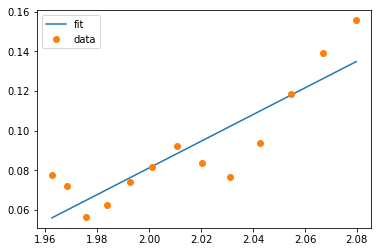

In [49]:
#create dictionaries of data with exposure as keys
stdDict1 = {}
meanDict1 = {}
varDict1 = {}
#grab 100 frames with aperture open to obtain signal 
#might have to manually change exposure due to issues with camera 
dev = ok.okCFrontPanel()
deviceCount = dev.GetDeviceCount()
for i in range(deviceCount):
    print 'Device[{0}] Model: {1}'.format(i, dev.GetDeviceListModel(i))
    print 'Device[{0}] Serial: {1}'.format(i, dev.GetDeviceListSerial(i))

dev = ok.okCFrontPanel()
dev.OpenBySerial("")
dev.ConfigureFPGA("ok_imager.bit")
if dev.IsFrontPanelEnabled():

    exp =3.8
    exposure = int(10**exp)
    
    while exp<4.4:
        offset1 = cv2.imread(str(int(exposure))+'.png',0)
        row = 160
        N_adc = 4
        N_adcCh = 3
        N_mux = 46
        col = N_adc*N_adcCh*N_mux
        datain128 = bytearray(262144)
        datain1 = bytearray(88320)
        im = np.zeros((row ,col))
        im1 = np.zeros((79 ,60))
        im2 = np.zeros((79 ,60))
        sample1 = np.zeros((79,60))
        sample2 = np.zeros((79,60))
        data1 = np.zeros((100,79,60))
        imgcheck = np.zeros((79,60))
        elsecounter = 0 
        rep = 0
        print exposure
        offset1 = cv2.imread(str(int(exposure))+'.png',0)
        
        dev.SetWireInValue(0x11,exposure)
        dev.SetWireInValue(0x12,1)
        dev.SetWireInValue(0x13,0)
        dev.SetWireInValue(0x14,0)
        dev.SetWireInValue(0x15, 0xfff003ff)
        dev.UpdateWireIns()
        time.sleep(0.01)
        # assert reset signal to initialize the FIFO
        dev.SetWireInValue(0x10, 0xff, 0x01)
        dev.UpdateWireIns()
        # deactivate reset signal and activate counter.
        dev.SetWireInValue(0x10, 0x00, 0x01)
        dev.UpdateWireIns()
        time.sleep(0.1)

        while rep<12:
            dev.UpdateTriggerOuts()
            # If the FIFO is full, read everything and display one frame only
            if dev.IsTriggered(0x6A, 0x01) == True:
                dev.ReadFromPipeOut(0xA0, datain128)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain128[i*col+l*N_adc*N_adcCh+k*N_adc+j]
                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):
                    rep+=1
                    if rep==11:
                        sample1 = im1 - offset1
                    elif rep ==12:
                        sample2 = im1 - offset1

            # If one frame is ready in FIFO
            elif dev.IsTriggered(0x6A, 0x02) == True:
                dev.ReadFromPipeOut(0xA0, datain1)
                for i in range(row):
                    for j in range(N_adc):
                        for k in range(N_adcCh):
                            for l in range(N_mux):
                                im[row-1-i][col-1-(j*N_adcCh*N_mux+(2-k)*N_mux+45-l)] = datain1[i*col+l*N_adc*N_adcCh+k*N_adc+j]

                im1[:,:] = im[1:80,142:262:2]
                if np.any(im1):
                    rep+=1
                    if rep==11:
                        sample1 = im1 - offset1
                    elif rep ==12:
                        sample2 = im1 - offset1
            else:
                elsecounter += 1
                print elsecounter
                if elsecounter>10:
                    elsecounter = 0
                    # assert reset signal to initialize the FIFO
                    dev.SetWireInValue(0x10, 0xff, 0x01)
                    dev.UpdateWireIns()
                    # deactivate reset signal and activate counter.
                    dev.SetWireInValue(0x10, 0x00, 0x01)
                    dev.UpdateWireIns()
        #compute the standard deviation and average signal of each pixel 
        mean = np.mean(sample1)
        std = np.std(sample1-sample2)
        var = np.var(sample1-sample2)
        cv2.imwrite(str(exposure)+'test1.png', sample1)#make sure the data is ok
        cv2.imwrite(str(exposure)+'test2.png', sample2)#make sure the data is ok
        stdDict1[exposure] = std
        meanDict1[exposure]= mean
        varDict1[exposure]= var

        exp +=0.05
        exposure = int(10**exp)
    x = np.zeros(len(stdDict1.keys()))
    y = np.zeros(len(stdDict1.keys()))
    i = 0
    for key in sorted(stdDict1.keys()):
        x[i] = math.log(meanDict1[key],10)
        y[i] = math.log(stdDict1[key],10)
        i +=1
    p=np.poly1d(np.polyfit(x,y,1))
    print (np.poly1d(p))
    plt.plot(x, p(x), label = 'fit', linestyle = '-')
    plt.plot(x,y,'o',label = 'data')
    plt.legend()
    plt.show()
else:
    print("FrontPanel host interface not detected.")

 
0.02129 x - 0.676


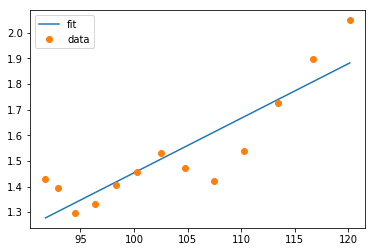

In [50]:
x = np.zeros(len(stdDict1.keys()))
y = np.zeros(len(stdDict1.keys()))
i = 0
for key in sorted(stdDict1.keys()):
    x[i] = meanDict1[key]
    y[i] = varDict1[key]
    i +=1
p=np.poly1d(np.polyfit(x,y,1))
print (np.poly1d(p))
plt.plot(x, p(x), label = 'fit', linestyle = '-')
plt.plot(x,y,'o',label = 'data')
plt.legend()
plt.show()

In [51]:
import pickle

#save dictionaries

with open('stdDict1.pkl', 'wb') as output:
    pickle.dump(stdDict1, output)

with open('meanDict1.pkl', 'wb') as output:
    pickle.dump(meanDict1, output)
    
with open('varDict1.pkl', 'wb') as output:
    pickle.dump(varDict1, output)    


 
0.674 x - 1.267


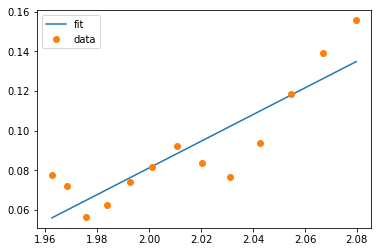

In [52]:
import math
import matplotlib.pyplot as plt
import numpy as np
#load dictionaries to plot data
with open('stdDict1.pkl', "rb") as fp:
    stdDict = pickle.load(fp) 

with open('meanDict1.pkl', "rb") as fp:
    meanDict = pickle.load(fp) 
    
with open('varDict1.pkl', "rb") as fp:
    varDict = pickle.load(fp)   
x = np.zeros(len(stdDict1.keys()))
y = np.zeros(len(stdDict1.keys()))
i = 0
for key in sorted(stdDict1.keys()):
    x[i] = math.log(meanDict1[key],10)
    y[i] = math.log(stdDict1[key],10)
    i +=1
p=np.poly1d(np.polyfit(x,y,1))
print (np.poly1d(p))
plt.plot(x, p(x), label = 'fit', linestyle = '-')
plt.plot(x,y,'o',label = 'data')
plt.legend()
plt.show()